###  Chemiscope Auto

In [1]:
import ase.io
from mace.calculators import mace_off, mace_mp
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import chemiscope

Load QM9

In [2]:
from load_atoms import load_dataset

frames = load_dataset("QM9")
frames = frames[::25]

Output()

SOAP

In [24]:
import rascaline
from rascaline.calculators import SoapPowerSpectrum
from metatensor import mean_over_samples


hypers_ps = {
    "cutoff": 5.,
    "max_radial": 6,
    "max_angular": 6,
    "atomic_gaussian_width": 0.3,
    "center_atom_weight": 0.0,
    "radial_basis": {
        "Gto": {},
    },
    "cutoff_function": {
        "ShiftedCosine": {"width":0.5},
    },
    "radial_scaling":{"Willatt2018": {"exponent": 7.0, "rate": 1.0, "scale": 2.0}}
}

# calculator object to compute features initialize with hypers
calculator = SoapPowerSpectrum(**hypers_ps)

In [25]:
feat = calculator.compute(frames)

feat = feat.keys_to_samples(["center_type"])
feat = feat.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])

feat = mean_over_samples(feat, sample_names=["atom", "center_type"])

Xfeat = feat.block(0).values

In [26]:
Xfeat.shape

(5356, 3780)

### Computation of features

In [3]:
def compute_mace_features(frames, calculator, invariants_only=True):
    descriptors = []
    for frame in tqdm(frames):
        structure_avg = np.mean(
            (calculator.get_descriptors(frame, invariants_only=invariants_only)),
            axis=0,
        )
        descriptors.append(structure_avg)
    return np.array(descriptors)

In [4]:
def save_descriptors(file_name, descriptors):
    np.save(file_name, descriptors)

In [5]:
import numpy as np


def load_or_compute_descriptors(file_name, frames, calculator, invariants_only=False):
    if os.path.exists(file_name):
        print(f"Loading descriptors from {file_name}")
        descriptors = np.load(file_name)
    else:
        print(f"Computing descriptors and saving to {file_name}")
        descriptors = compute_mace_features(frames, calculator, invariants_only)
        np.save(file_name, descriptors)
    return descriptors

Initialize calculators

In [6]:
descriptor_opt = {"model": "small", "device": "cpu", "default_dtype": "float64"}
calculator_mace_off = mace_off(**descriptor_opt)
calculator_mace_mp = mace_mp(**descriptor_opt)

Using MACE-OFF23 MODEL for MACECalculator with /home/chorna/.cache/mace/MACE-OFF23_small.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using Materials Project MACE for MACECalculator with /home/chorna/.cache/mace/46jrkm3v
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


Load or calculate MACE-OFF and MACE-MP features

In [7]:
mace_mp_features_file = "data/descriptors_MACE_MP0_all.npy"
mace_mp_features = load_or_compute_descriptors(
    mace_mp_features_file, frames, calculator_mace_mp
)

mace_off_features_file = "data/descriptors_MACE_OFF_all.npy"
mace_off_features = load_or_compute_descriptors(
    mace_off_features_file, frames, calculator_mace_off
)

Loading descriptors from data/descriptors_MACE_MP0_all.npy
Loading descriptors from data/descriptors_MACE_OFF_all.npy


### Perform deminsionality reduction technics on the MACE features

In [8]:
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
import umap
from sklearn.manifold import TSNE
import numpy as np

In [35]:
import time
import os
import joblib
import numpy as np
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
import umap

def dimensionality_reduction_analysis(descriptors, method="PCA", use_gpu=False, save_path="data"):
    reducer_path = os.path.join(save_path, f"{method}_reducer.pkl")
    points_path = os.path.join(save_path, f"{method}_points.npy")

    if os.path.exists(reducer_path) and os.path.exists(points_path):
        print(f"Loading existing reducer and points for {method}...")
        reducer = joblib.load(reducer_path)
        X_reduced = np.load(points_path)
        execution_time = 0  # Since no computation was done
    else:
        start_time = time.time()

        if method == "PCA":
            reducer = PCA(n_components=2)
        elif method == "UMAP":
            reducer = umap.UMAP(
                n_components=2,
                n_neighbors=15,
                min_dist=0.1,
                metric="euclidean",
                target_metric="categorical",
            )
        elif method == "TSNE":
            perplexity = min(30, descriptors.shape[0] - 1)
            reducer = TSNE(n_components=2, perplexity=perplexity)
        elif method == "ICA":
            reducer = FastICA(n_components=2)
        else:
            raise ValueError("Invalid method name.")

        X_reduced = reducer.fit_transform(descriptors)

        # Save the reducer and reduced points to files
        os.makedirs(save_path, exist_ok=True)
        joblib.dump(reducer, reducer_path)
        np.save(points_path, X_reduced)

        execution_time = time.time() - start_time
        print(f"{method} execution time: {execution_time:.2f} seconds")

    return X_reduced, execution_time


Loading existing reducer and points for PCA...
Loading existing reducer and points for UMAP...
Loading existing reducer and points for TSNE...
Loading existing reducer and points for ICA...
Loading existing reducer and points for PCA...
Loading existing reducer and points for UMAP...
Loading existing reducer and points for TSNE...
Loading existing reducer and points for ICA...


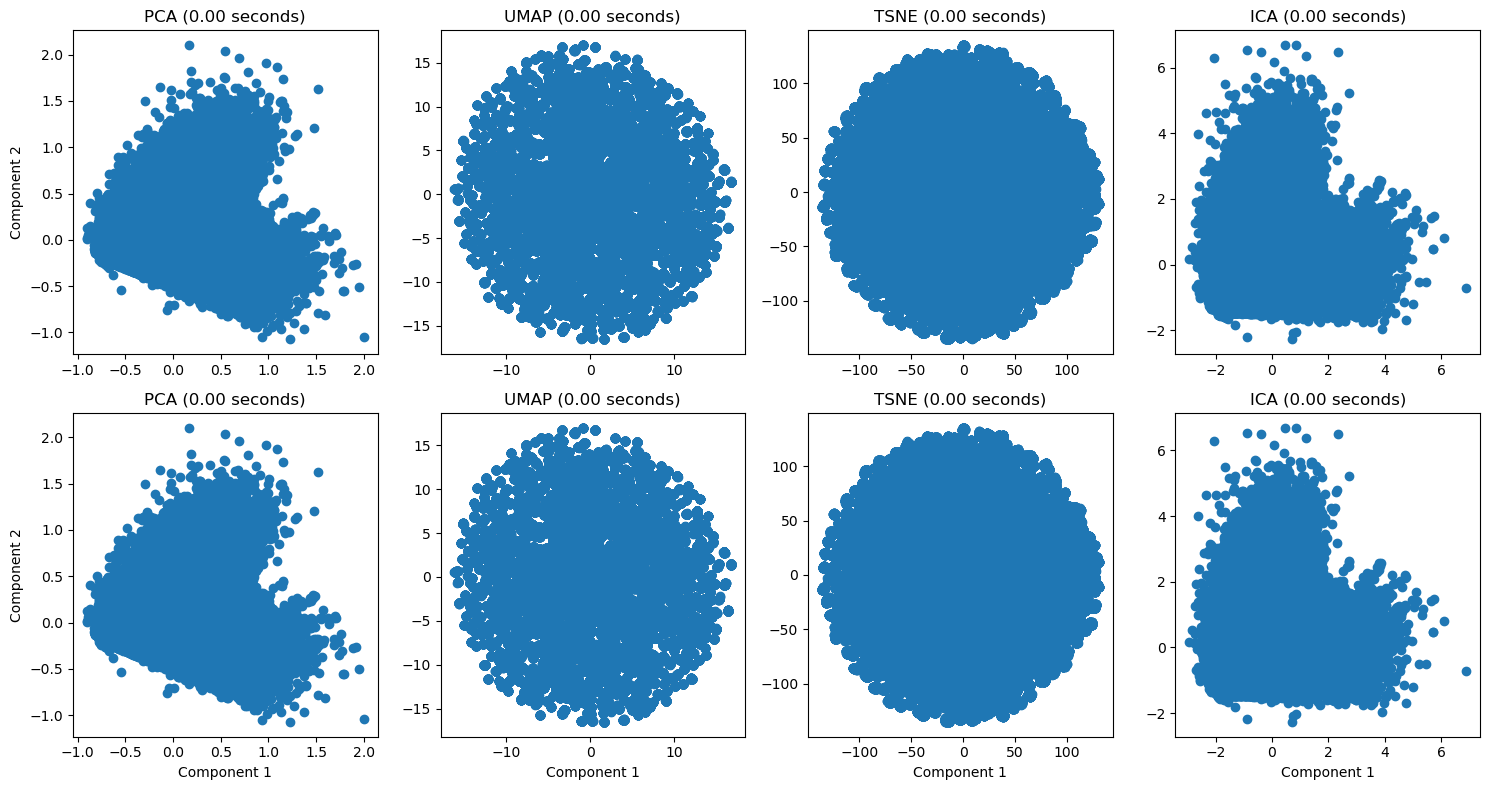

In [36]:
methods = ["PCA", "UMAP", "TSNE", "ICA"]
use_gpu = [False, False, True, False]
descriptors = [mace_off_features, mace_mp_features]

fig, axes = plt.subplots(2, len(methods), figsize=(15, 8))

for i, descriptors in enumerate(descriptors):
    for j, method in enumerate(methods):
        ax = axes[i, j]
        X_reduced, execution_time = dimensionality_reduction_analysis(
            descriptors, method=method, use_gpu=use_gpu[j]
        )
        ax.scatter(X_reduced[:, 0], X_reduced[:, 1])
        ax.set_title(f"{method} ({execution_time:.2f} seconds)")
        if i == 1:
            ax.set_xlabel("Component 1")
        if j == 0:
            ax.set_ylabel("Component 2")

plt.tight_layout()
plt.show()

Dimensionality Reduction on the concatenated features

In [34]:
concatenated_features = np.concatenate((mace_off_features, mace_mp_features), axis=1)

PCA execution time: 0.72 seconds
UMAP execution time: 199.09 seconds
TSNE execution time: 900.37 seconds


/home/chorna/miniconda3/envs/chemiscope_auto/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA execution time: 7.35 seconds


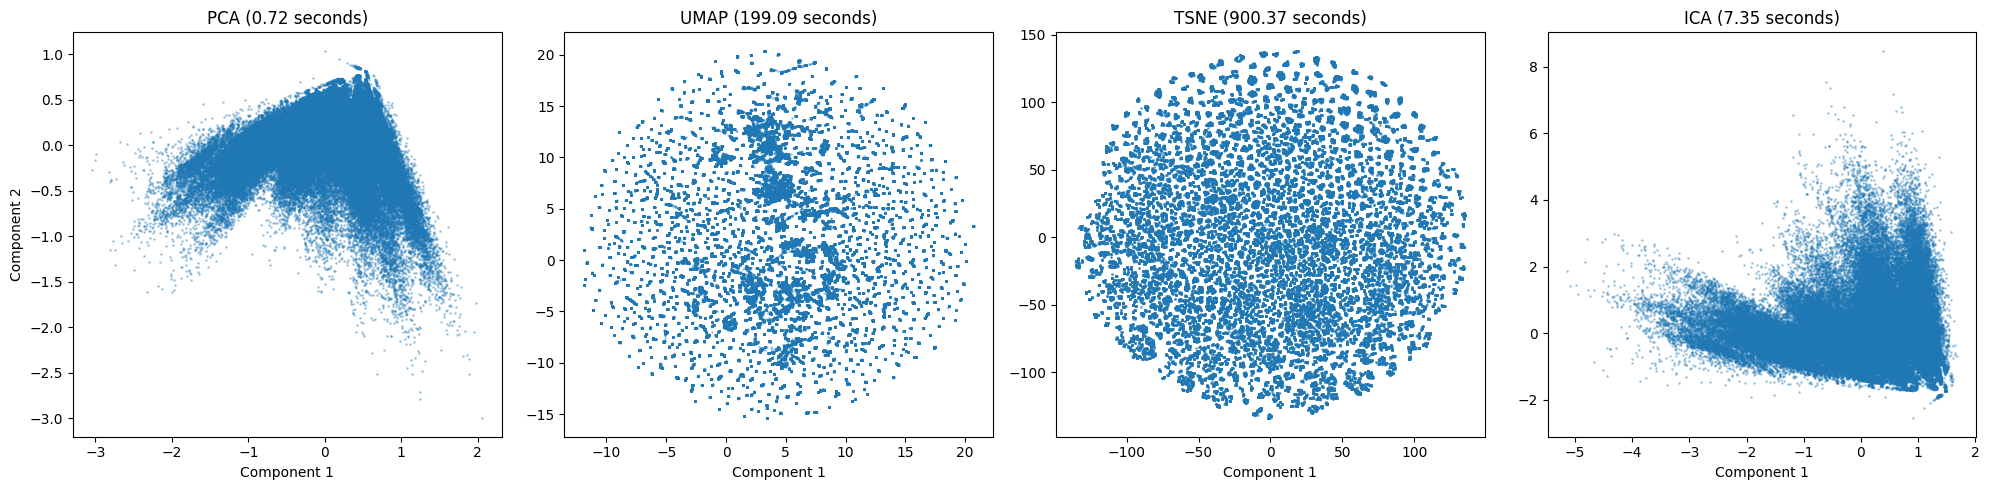

In [25]:
methods = ["PCA", "UMAP", "TSNE", "ICA"]
use_gpu = [False, False, True, False]

_fig, axes = plt.subplots(1, len(methods), figsize=(20, 5))

for j, method in enumerate(methods):
    ax = axes[j]
    X_reduced, execution_time = dimensionality_reduction_analysis(
        concatenated_features, method=method, use_gpu=use_gpu[j]
    )
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.3, s=1)
    ax.set_title(f"{method} ({execution_time:.2f} seconds)")
    ax.set_xlabel("Component 1")
    if j == 0:
        ax.set_ylabel("Component 2")

plt.tight_layout()
plt.show()

### Methods separately

In [131]:
def show_plt(
    data, method_name, features_name, x_label="Component 1", y_label="Component 2"
):
    plt.scatter(data[:, 0], data[:, 1], alpha=0.1, s=1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"{method_name} of {features_name} Features")
    plt.show()

#### PCA

In [132]:
from sklearn.decomposition import PCA


def apply_pca(descriptors):
    return PCA(n_components=2).fit_transform(descriptors)

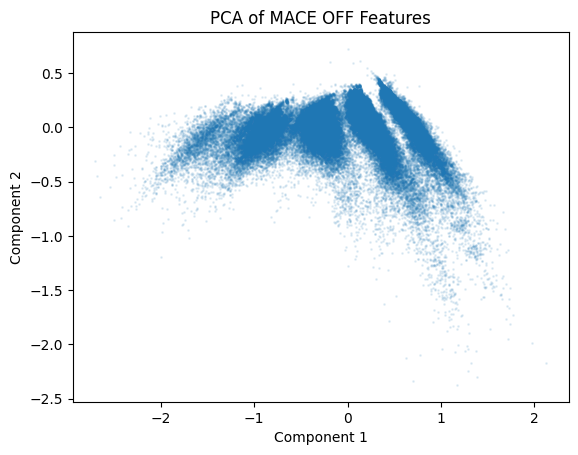

In [133]:
X_pca_mace_off = apply_pca(mace_off_features)

show_plt(X_pca_mace_off, method_name="PCA", features_name="MACE OFF")

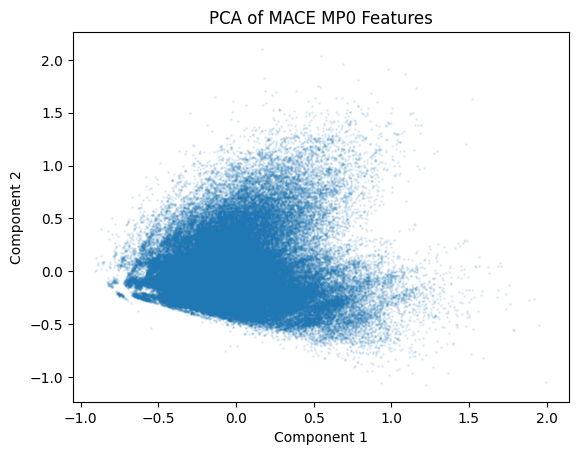

In [134]:
X_pca_mace_mp = apply_pca(mace_mp_features)

show_plt(X_pca_mace_mp, method_name="PCA", features_name="MACE MP0")

#### UMAP

In [135]:
import umap


def apply_umap(descriptors):
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="euclidean",
        target_metric="categorical",
    )
    return reducer.fit_transform(descriptors)

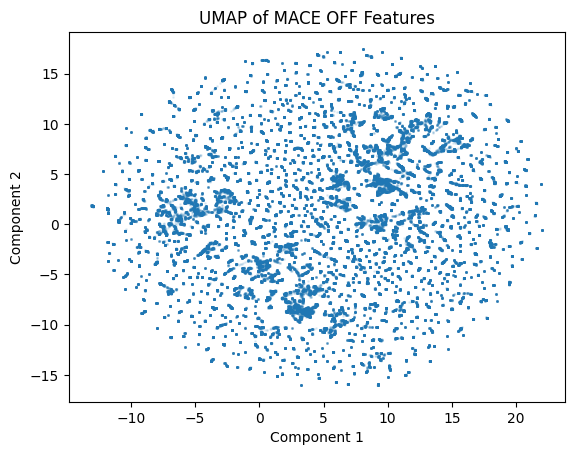

In [136]:
X_umap_mace_off = apply_umap(mace_off_features)

show_plt(X_umap_mace_off, method_name="UMAP", features_name="MACE OFF")

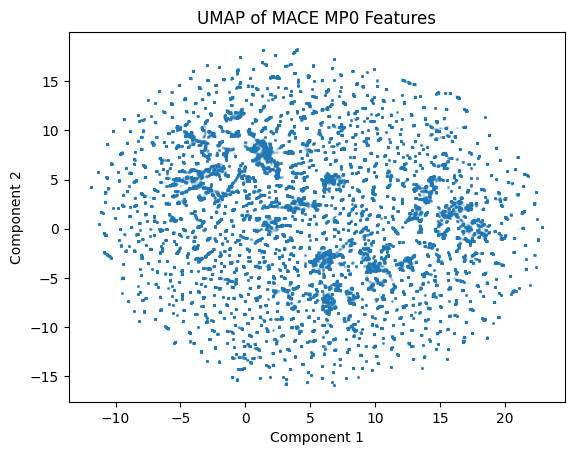

In [137]:
X_umap_mace_mp = apply_umap(mace_off_features)

show_plt(X_umap_mace_mp, method_name="UMAP", features_name="MACE MP0")

#### TSNE

In [138]:
from sklearn.manifold import TSNE


def apply_tsne(descriptors):
    return TSNE(n_components=2).fit_transform(descriptors)

In [141]:
X_tsne_mace_off = apply_tsne(mace_off_features)

show_plt(X_tsne_mace_off, method_name="TSNE", features_name="MACE OFF")

In [142]:
X_tsne_mace_mp = apply_tsne(mace_mp_features)

show_plt(X_tsne_mace_mp, method_name="TSNE", features_name="MACE MP0")

#### ICA

In [ ]:
from sklearn.decomposition import FastICA


def apply_ica(descriptors):
    reducer = FastICA(n_components=2)
    return reducer.fit_transform(descriptors)

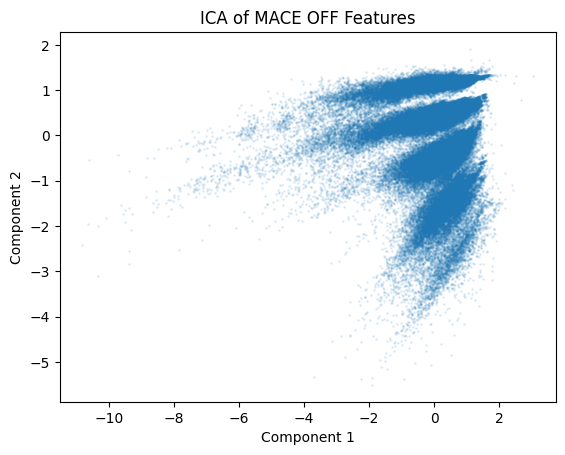

In [ ]:
X_ica_mace_off = apply_ica(mace_off_features)

show_plt(X_ica_mace_off, method_name="ICA", features_name="MACE OFF")

In [143]:
X_ica_mace_mp = apply_ica(mace_mp_features)

show_plt(X_ica_mace_mp, method_name="ICA", features_name="MACE MP0")

### Chemiscope Visualisation

Extracting all properties

In [144]:
def extract_properties(frames):
    properties = {prop: [] for prop in frames[0].info.keys()}
    for frame in frames:
        for prop, value in frame.info.items():
            properties[prop].append(value)
    return properties


properties = extract_properties(frames)

In [145]:
EVERY_N = 25


def display_chemiscope(X_pca, properties, meta):
    return chemiscope.show(
        frames=frames[::EVERY_N],
        properties={
            "PCA 1": {"target": "structure", "values": X_pca[:, 0][::EVERY_N].tolist()},
            "PCA 2": {"target": "structure", "values": X_pca[:, 1][::EVERY_N].tolist()},
            "homo": {"target": "structure", "values": properties["homo"][::EVERY_N]},
            "lumo": {"target": "structure", "values": properties["lumo"][::EVERY_N]},
            "gap": {"target": "structure", "values": properties["gap"][::EVERY_N]},
        },
        meta=meta,
    )

MACE OFF

In [146]:
display_chemiscope(X_pca_mace_off, properties, meta={"name": "QM9 MACE OFF features"})

<ChemiscopeWidget(meta={'name': 'QM9 MACE OFF features'}, structures=[{'size': 5, 'names': ['C', 'H', 'H', 'H'…

MACE MP

In [147]:
display_chemiscope(X_pca_mace_mp, properties, meta={"name": "QM9 MACE MP features"})

<ChemiscopeWidget(meta={'name': 'QM9 MACE MP features'}, structures=[{'size': 5, 'names': ['C', 'H', 'H', 'H',…